Inicializar

In [1]:
import os
import shutil
from PIL import Image
from image_similarity_measures.evaluate import evaluation
import bitmath
import matplotlib.pyplot as plt
import cv2

def get_size_format(b, factor=1024, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if b < factor:
            return f"{b:.2f}{unit}{suffix}"
        b /= factor
    return f"{b:.2f}Y{suffix}"


if not os.path.exists("input"):
    os.makedirs("input")
    
if not os.path.exists("output"):
    os.makedirs("output")

Limpar output

In [13]:
def limpar(dir):
    if os.path.exists(dir):
        shutil.rmtree(dir)
        os.makedirs(dir)
    
limpar("output")
limpar("outputCV2")    
limpar("decompressed")

Ativar graficos interativos

In [5]:
%matplotlib notebook

Desativar Graficos interativos

In [6]:
%matplotlib inline

Comprimir

In [ ]:
def compression_pillow(path, outputPath = "output", quality = 90, extension = None, optimize = False):
    img = Image.open(path)
    imgSize = os.path.getsize(path)
    nameImg, imgExtenssion = os.path.splitext(os.path.basename(path))
    outputPath = f"{outputPath}/{nameImg}"
    
    if extension is None:
        extension = imgExtenssion
        
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
    
    outputFilePath = f"{outputPath}/{nameImg}_compressed_{quality}{extension}"
    img.save(outputFilePath, quality = quality, optimize = optimize)
    compressedSize = os.path.getsize(outputFilePath)
    
    print(f"{nameImg}: in quality {quality} redution of {(imgSize-compressedSize)/imgSize*100:.2f}%. Size {get_size_format(compressedSize)}")



qualities = range(10,100,10)
for quality in qualities:
    compression_pillow("input/Imagem112KB.jpg", "output", quality, None, True)
    compression_pillow("input/Imagem4MB.jpg", "output", quality, None, True)
    print("="*50)

Compressão com OpenCV

In [ ]:
def compression_cv2(path, outputPath = "outputCV2", quality = 90, extension = None):
    img = cv2.imread(path)
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    imgSize = os.path.getsize(path)
    nameImg, imgExtenssion = os.path.splitext(os.path.basename(path))
    outputPath = f"{outputPath}/{nameImg}"

    if extension is None:
        extension = imgExtenssion
        
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

    outputFilePath = f"{outputPath}/{nameImg}_compressed_{quality}{extension}"

    result, encimg = cv2.imencode(extension, img, encode_param)
    
    with open(outputFilePath, 'wb') as f:
        f.write(encimg)
    
    compressedSize = os.path.getsize(outputFilePath)
    print(f"{nameImg}: in quality {quality} redution of {(imgSize-compressedSize)/imgSize*100:.2f}%. Size {get_size_format(compressedSize)}")
    
    
qualities = range(10,100,10)
for quality in qualities:
    compression_cv2("input/Imagem112KB.jpg", "outputCV2", quality, None)
    compression_cv2("input/Imagem4MB.jpg", "outputCV2", quality, None)
    print("="*50)

Descompressão de imagens comprimidas com opencv (não traz resultados significativos)

In [52]:
def decompression_cv2(nameImg, dir, extension = ".jpg"):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 90]
    for compressedImg in os.listdir(f"{dir}/{nameImg}"):
        compressedImgName = os.path.splitext(compressedImg)[0]
        img = cv2.imread(f"{dir}/{nameImg}/{compressedImg}")
        result, encimg = cv2.imencode(extension, img, encode_param)
        decimg = cv2.imdecode(encimg, cv2.IMREAD_COLOR)
    
        cv2.imwrite(f"decompressed/{nameImg}/{compressedImgName}{extension}", decimg) 
        
        
decompression_cv2("Imagem4MB", "outputCV2")

Analize da redução de qualidade (Perda de qualidade em função do nivel de compressão)

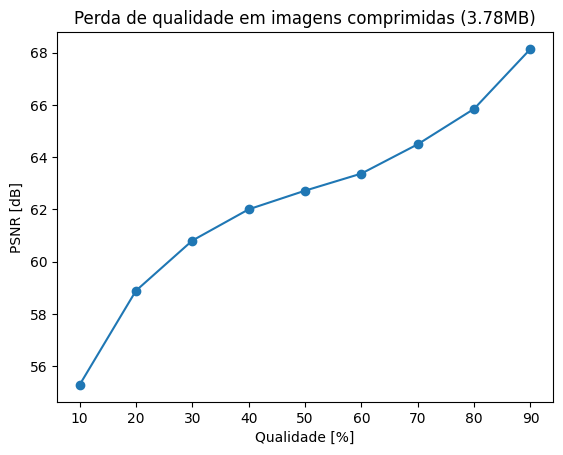

In [53]:
def qualityLoss(img, dir = "output", x = qualities, metric = "psnr"):
    y = []
    imgName, imgExtension = os.path.splitext(img)
    for compressedImg in os.listdir(f"{dir}/{imgName}"):
        y.append(evaluation(f"input/{img}", f"{dir}/{imgName}/{compressedImg}", [metric])[metric])
        
    plt.plot(x, y, marker='o')
    plt.xlabel("Qualidade [%]")
    plt.ylabel("PSNR [dB]")
    plt.title(f"Perda de qualidade em imagens comprimidas ({get_size_format(os.path.getsize('input/'+img))})")
    plt.show()
    

# qualityLoss("Imagem112KB.jpg", "outputCV2")
qualityLoss("Imagem4MB.jpg", "decompressed")

Analize da redução de qualidade (Perda de qualidade em função do tamanho da imagem comprimida)

In [ ]:
def sizeLoss(img, dir = "output", metric = "psnr"):
    y = []
    x = []
    imgName, imgExtension = os.path.splitext(img)
    for compressedImg in os.listdir(f"{dir}/{imgName}"):
        pathCompressedImg = f"{dir}/{imgName}/{compressedImg}"
        y.append(evaluation(f"input/{img}", pathCompressedImg, [metric])[metric])
        x.append(bitmath.getsize(pathCompressedImg).to_kB().value)
        
    plt.plot(x, y, marker='o')
    # plt.xticks(range(int(min(x)), int(max(x))+1, int(max(x)*0.10)))
    plt.xlabel("Tamanho [KB]")
    plt.ylabel("PSNR [dB]")
    plt.title(f"Perda de qualidade em imagens comprimidas ({get_size_format(os.path.getsize('input/'+img))})")
    plt.show()
    
    
# sizeLoss("Imagem112KB.jpg", "outputCV2")
sizeLoss("Imagem4MB.jpg", "decompressed")